# Simple LSTM Model

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
train_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_x.csv')
train_y = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_y.csv')
test_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/test_x.csv')

In [3]:
# Display the first few rows
print(train_x.head())
print(train_x.shape)

   Hour  ID    Age  Gender  Unit1  Unit2     HR   O2Sat   Temp     SBP  ...  \
0     1   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
1     2   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
2     3   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
3     4   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
4     5   2  66.67     1.0    0.0    1.0  84.42   99.58  35.61  114.60  ...   

   Phosphate  Potassium  Bilirubin_total  TroponinI    Hct   Hgb  PTT   WBC  \
0        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
1        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
2        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
3        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
4        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   

   Fibrinogen  Platelets  
0         NaN        Na

In [4]:
print(train_y.head())
print(train_y.shape)

   ID  Outcome
0   2        0
1   3        0
2   5        1
3   6        0
4  13        0
(12115, 2)


In [5]:
max_hours = train_x.groupby('ID')['Hour'].count().max()
print(f'Maximum number of hours: {max_hours}')

Maximum number of hours: 336


In [6]:
# Get unique person IDs
person_ids = train_x['ID'].unique()

# Initialize tensors for features, masks, and time intervals
num_persons = len(person_ids)
num_features = train_x.shape[1] - 2  # excluding 'ID' and 'Hour' columns

In [7]:
person_ids

array([    2,     3,     5, ..., 21630, 21632, 21633])

In [8]:
#Initialize tensors
X_tensor = np.zeros((num_persons, max_hours, num_features+1))

In [9]:
for i, person_id in enumerate(person_ids):
    person_data = train_x[train_x['ID'] == person_id].sort_values('Hour')
    hours = person_data['Hour'].values
    features = person_data.drop(columns=['ID']).values
    
    # Fill X_tensor
    X_tensor[i, :len(hours), :] = features

In [10]:
X_tensor

array([[[  1.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  2.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  3.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  2.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  3.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  2.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  3.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        ...,
        [  0

In [11]:
# Replace NaNs with zeros in X_tensor
X_tensor = np.nan_to_num(X_tensor)

print(X_tensor.shape)

(12115, 336, 39)


In [12]:
# Ensure train_y is aligned with X_tensor
labels = np.zeros(len(person_ids))

for i, person_id in enumerate(person_ids):
    if person_id in train_y['ID'].values:
        labels[i] = train_y[train_y['ID'] == person_id]['Outcome'].values[0]

print(labels.shape)

(12115,)


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, labels, test_size=0.2, random_state=10
)

In [14]:
def create_lstm_model(input_shape, learning_rate=0.001, dropout_rate=0.2, regularization_factor=0.001):
    x_input = Input(shape=input_shape)
    
    # LSTM layers with dropout, batch normalization, and regularization
    lstm_output = LSTM(units=64, return_sequences=False, kernel_regularizer=l2(regularization_factor))(x_input)
    lstm_output = BatchNormalization()(lstm_output)
    lstm_output = Dropout(dropout_rate)(lstm_output)
    
    # Output layer
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(regularization_factor))(lstm_output)
    
    # Create model
    model = Model(inputs=x_input, outputs=output)
    
    # Create an Adam optimizer with a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC', 'accuracy'])
    
    return model

In [15]:
input_shape = (max_hours, num_features+1)
model_lstm = create_lstm_model(input_shape)

history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 5:12 646ms/step - AUC: 0.5000 - accuracy: 0.9375 - loss: 0.7629

  3/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.5071 - accuracy: 0.9236 - loss: 0.7604  

  5/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.4972 - accuracy: 0.9067 - loss: 0.7581

  7/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.5045 - accuracy: 0.9004 - loss: 0.7556

  9/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.5034 - accuracy: 0.8956 - loss: 0.7532

 11/485 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 0.4994 - accuracy: 0.8913 - loss: 0.7509

 13/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.5010 - accuracy: 0.8892 - loss: 0.7485

 15/485 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 0.4993 - accuracy: 0.8870 - loss: 0.7462

 17/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4965 - accuracy: 0.8850 - loss: 0.7439

 19/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4947 - accuracy: 0.8834 - loss: 0.7416

 21/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4926 - accuracy: 0.8817 - loss: 0.7394

 23/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4887 - accuracy: 0.8796 - loss: 0.7373

 25/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4853 - accuracy: 0.8775 - loss: 0.7352

 27/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4826 - accuracy: 0.8754 - loss: 0.7332

 29/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4814 - accuracy: 0.8738 - loss: 0.7311

 31/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4803 - accuracy: 0.8723 - loss: 0.7290

 33/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4794 - accuracy: 0.8709 - loss: 0.7269

 35/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4778 - accuracy: 0.8693 - loss: 0.7249

 37/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4766 - accuracy: 0.8679 - loss: 0.7229

 39/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4762 - accuracy: 0.8667 - loss: 0.7208

 41/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.4766 - accuracy: 0.8657 - loss: 0.7187

 43/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.4772 - accuracy: 0.8649 - loss: 0.7166

 45/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.4787 - accuracy: 0.8645 - loss: 0.7143

 47/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4804 - accuracy: 0.8641 - loss: 0.7120

 49/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4821 - accuracy: 0.8638 - loss: 0.7097

 51/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4837 - accuracy: 0.8635 - loss: 0.7074

 53/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4854 - accuracy: 0.8634 - loss: 0.7050

 55/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4870 - accuracy: 0.8632 - loss: 0.7027

 57/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4885 - accuracy: 0.8631 - loss: 0.7004

 59/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4900 - accuracy: 0.8631 - loss: 0.6981

 61/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4913 - accuracy: 0.8630 - loss: 0.6958

 63/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4925 - accuracy: 0.8629 - loss: 0.6935

 65/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4939 - accuracy: 0.8630 - loss: 0.6911

 67/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4954 - accuracy: 0.8630 - loss: 0.6888

 69/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4968 - accuracy: 0.8631 - loss: 0.6864

 71/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4981 - accuracy: 0.8632 - loss: 0.6841

 73/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4989 - accuracy: 0.8632 - loss: 0.6819

 75/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.4994 - accuracy: 0.8632 - loss: 0.6797

 77/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.5001 - accuracy: 0.8632 - loss: 0.6775

 79/485 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 0.5009 - accuracy: 0.8632 - loss: 0.6753

 81/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5017 - accuracy: 0.8633 - loss: 0.6731

 83/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5025 - accuracy: 0.8634 - loss: 0.6709

 85/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5033 - accuracy: 0.8635 - loss: 0.6687

 87/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5040 - accuracy: 0.8636 - loss: 0.6665

 89/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5047 - accuracy: 0.8637 - loss: 0.6643

 91/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5054 - accuracy: 0.8637 - loss: 0.6622

 93/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5061 - accuracy: 0.8639 - loss: 0.6600

 95/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5067 - accuracy: 0.8640 - loss: 0.6579

 97/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5071 - accuracy: 0.8640 - loss: 0.6559

 99/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5075 - accuracy: 0.8641 - loss: 0.6539

101/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5080 - accuracy: 0.8642 - loss: 0.6518

103/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5086 - accuracy: 0.8643 - loss: 0.6498

105/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5092 - accuracy: 0.8645 - loss: 0.6477

107/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5096 - accuracy: 0.8646 - loss: 0.6457

109/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5099 - accuracy: 0.8646 - loss: 0.6438

111/485 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 0.5103 - accuracy: 0.8647 - loss: 0.6419

113/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5107 - accuracy: 0.8648 - loss: 0.6400

115/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5109 - accuracy: 0.8649 - loss: 0.6381

117/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5112 - accuracy: 0.8650 - loss: 0.6363

119/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5116 - accuracy: 0.8651 - loss: 0.6344

121/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5119 - accuracy: 0.8652 - loss: 0.6326

123/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5123 - accuracy: 0.8653 - loss: 0.6308

125/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5126 - accuracy: 0.8654 - loss: 0.6290

127/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5129 - accuracy: 0.8655 - loss: 0.6272

129/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5132 - accuracy: 0.8656 - loss: 0.6254

131/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5136 - accuracy: 0.8657 - loss: 0.6237

133/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5139 - accuracy: 0.8658 - loss: 0.6219

135/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5141 - accuracy: 0.8659 - loss: 0.6203

137/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5143 - accuracy: 0.8660 - loss: 0.6186

139/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5144 - accuracy: 0.8661 - loss: 0.6170

141/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5145 - accuracy: 0.8661 - loss: 0.6155

143/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5146 - accuracy: 0.8662 - loss: 0.6139

145/485 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5147 - accuracy: 0.8663 - loss: 0.6124

147/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5148 - accuracy: 0.8663 - loss: 0.6108 

149/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5149 - accuracy: 0.8664 - loss: 0.6093

151/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5150 - accuracy: 0.8665 - loss: 0.6079

153/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5150 - accuracy: 0.8665 - loss: 0.6064

155/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5151 - accuracy: 0.8666 - loss: 0.6050

157/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5151 - accuracy: 0.8666 - loss: 0.6036

159/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5151 - accuracy: 0.8667 - loss: 0.6022

161/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5150 - accuracy: 0.8667 - loss: 0.6009

163/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5150 - accuracy: 0.8667 - loss: 0.5996

165/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5149 - accuracy: 0.8668 - loss: 0.5983

167/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5149 - accuracy: 0.8668 - loss: 0.5970

169/485 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 0.5149 - accuracy: 0.8669 - loss: 0.5957

171/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5149 - accuracy: 0.8669 - loss: 0.5944

173/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5149 - accuracy: 0.8670 - loss: 0.5931

175/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5148 - accuracy: 0.8670 - loss: 0.5919

177/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5148 - accuracy: 0.8670 - loss: 0.5907

179/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5148 - accuracy: 0.8671 - loss: 0.5894

181/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5148 - accuracy: 0.8671 - loss: 0.5882

183/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5147 - accuracy: 0.8672 - loss: 0.5871

185/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5146 - accuracy: 0.8672 - loss: 0.5859

187/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5146 - accuracy: 0.8672 - loss: 0.5848

189/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5145 - accuracy: 0.8673 - loss: 0.5837

191/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5143 - accuracy: 0.8673 - loss: 0.5826

193/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5142 - accuracy: 0.8673 - loss: 0.5815

195/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5141 - accuracy: 0.8673 - loss: 0.5805

197/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5140 - accuracy: 0.8673 - loss: 0.5794

199/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5138 - accuracy: 0.8674 - loss: 0.5784

201/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5136 - accuracy: 0.8674 - loss: 0.5774

203/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5134 - accuracy: 0.8674 - loss: 0.5764

205/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5132 - accuracy: 0.8674 - loss: 0.5754

207/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5130 - accuracy: 0.8674 - loss: 0.5745

209/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5128 - accuracy: 0.8674 - loss: 0.5735

211/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5127 - accuracy: 0.8674 - loss: 0.5726

213/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5124 - accuracy: 0.8674 - loss: 0.5717

215/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5122 - accuracy: 0.8674 - loss: 0.5708

217/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5120 - accuracy: 0.8674 - loss: 0.5699

219/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5118 - accuracy: 0.8674 - loss: 0.5690

221/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5116 - accuracy: 0.8674 - loss: 0.5682

223/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5114 - accuracy: 0.8674 - loss: 0.5673

225/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5112 - accuracy: 0.8674 - loss: 0.5664

227/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5110 - accuracy: 0.8674 - loss: 0.5656

229/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5108 - accuracy: 0.8674 - loss: 0.5647

231/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5106 - accuracy: 0.8674 - loss: 0.5639

233/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5105 - accuracy: 0.8674 - loss: 0.5631

235/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5103 - accuracy: 0.8674 - loss: 0.5622

237/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5101 - accuracy: 0.8674 - loss: 0.5614

239/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5099 - accuracy: 0.8674 - loss: 0.5606

241/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5098 - accuracy: 0.8674 - loss: 0.5599

243/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5096 - accuracy: 0.8674 - loss: 0.5591

245/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5095 - accuracy: 0.8674 - loss: 0.5583

247/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5093 - accuracy: 0.8674 - loss: 0.5576

249/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5092 - accuracy: 0.8674 - loss: 0.5568

251/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5090 - accuracy: 0.8674 - loss: 0.5560

253/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5089 - accuracy: 0.8674 - loss: 0.5553

255/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5088 - accuracy: 0.8674 - loss: 0.5545

257/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5087 - accuracy: 0.8674 - loss: 0.5538

259/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5085 - accuracy: 0.8674 - loss: 0.5531

261/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5084 - accuracy: 0.8674 - loss: 0.5524

263/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5083 - accuracy: 0.8674 - loss: 0.5517

265/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5081 - accuracy: 0.8674 - loss: 0.5510

267/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5080 - accuracy: 0.8674 - loss: 0.5503

269/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5079 - accuracy: 0.8674 - loss: 0.5496

271/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5077 - accuracy: 0.8674 - loss: 0.5489

273/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5076 - accuracy: 0.8674 - loss: 0.5483

275/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5075 - accuracy: 0.8674 - loss: 0.5476

277/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5074 - accuracy: 0.8674 - loss: 0.5469

279/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5073 - accuracy: 0.8674 - loss: 0.5463

281/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5072 - accuracy: 0.8674 - loss: 0.5457

283/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5070 - accuracy: 0.8674 - loss: 0.5450

285/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5069 - accuracy: 0.8674 - loss: 0.5444

287/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5068 - accuracy: 0.8674 - loss: 0.5438

289/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5067 - accuracy: 0.8674 - loss: 0.5432

291/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5066 - accuracy: 0.8674 - loss: 0.5426

293/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5065 - accuracy: 0.8674 - loss: 0.5419

295/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5064 - accuracy: 0.8674 - loss: 0.5413

297/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5063 - accuracy: 0.8674 - loss: 0.5407

299/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5062 - accuracy: 0.8674 - loss: 0.5401

301/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5061 - accuracy: 0.8674 - loss: 0.5395

303/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5060 - accuracy: 0.8674 - loss: 0.5390

305/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5059 - accuracy: 0.8674 - loss: 0.5384

307/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5059 - accuracy: 0.8674 - loss: 0.5378

309/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5058 - accuracy: 0.8674 - loss: 0.5372

311/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5057 - accuracy: 0.8674 - loss: 0.5366

313/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5056 - accuracy: 0.8674 - loss: 0.5361

315/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5056 - accuracy: 0.8674 - loss: 0.5355

317/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5055 - accuracy: 0.8674 - loss: 0.5350

319/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5055 - accuracy: 0.8675 - loss: 0.5344

321/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5054 - accuracy: 0.8675 - loss: 0.5338

323/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5054 - accuracy: 0.8675 - loss: 0.5333

325/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5054 - accuracy: 0.8675 - loss: 0.5327

327/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5053 - accuracy: 0.8675 - loss: 0.5322

329/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5053 - accuracy: 0.8675 - loss: 0.5316

331/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5053 - accuracy: 0.8675 - loss: 0.5311

333/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5052 - accuracy: 0.8675 - loss: 0.5306

335/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5052 - accuracy: 0.8675 - loss: 0.5301

337/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5051 - accuracy: 0.8675 - loss: 0.5295

339/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5051 - accuracy: 0.8676 - loss: 0.5290

341/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5050 - accuracy: 0.8676 - loss: 0.5285

343/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5050 - accuracy: 0.8676 - loss: 0.5280

345/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5049 - accuracy: 0.8676 - loss: 0.5275

347/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5049 - accuracy: 0.8676 - loss: 0.5271

349/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5048 - accuracy: 0.8676 - loss: 0.5266

351/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5047 - accuracy: 0.8676 - loss: 0.5261

353/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5047 - accuracy: 0.8676 - loss: 0.5257

355/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5047 - accuracy: 0.8676 - loss: 0.5252

357/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5046 - accuracy: 0.8676 - loss: 0.5247

359/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5046 - accuracy: 0.8676 - loss: 0.5242

361/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5046 - accuracy: 0.8676 - loss: 0.5238

363/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5045 - accuracy: 0.8676 - loss: 0.5233

365/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5045 - accuracy: 0.8676 - loss: 0.5229

367/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5045 - accuracy: 0.8676 - loss: 0.5224

369/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5044 - accuracy: 0.8676 - loss: 0.5220

371/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5044 - accuracy: 0.8676 - loss: 0.5215

373/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5044 - accuracy: 0.8676 - loss: 0.5211

375/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5043 - accuracy: 0.8676 - loss: 0.5206

377/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5043 - accuracy: 0.8676 - loss: 0.5202

379/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5042 - accuracy: 0.8676 - loss: 0.5198

381/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5042 - accuracy: 0.8676 - loss: 0.5194

383/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5041 - accuracy: 0.8676 - loss: 0.5189

385/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5041 - accuracy: 0.8676 - loss: 0.5185

387/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5040 - accuracy: 0.8676 - loss: 0.5181

389/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5040 - accuracy: 0.8676 - loss: 0.5177

391/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5039 - accuracy: 0.8676 - loss: 0.5173

393/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5039 - accuracy: 0.8676 - loss: 0.5169

395/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5038 - accuracy: 0.8676 - loss: 0.5165

397/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5038 - accuracy: 0.8676 - loss: 0.5161

399/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5037 - accuracy: 0.8676 - loss: 0.5158

401/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5037 - accuracy: 0.8676 - loss: 0.5154

403/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5036 - accuracy: 0.8676 - loss: 0.5150

405/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5036 - accuracy: 0.8676 - loss: 0.5146

407/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5035 - accuracy: 0.8676 - loss: 0.5143

409/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5035 - accuracy: 0.8676 - loss: 0.5139

411/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5034 - accuracy: 0.8676 - loss: 0.5135

413/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5034 - accuracy: 0.8676 - loss: 0.5132

415/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5033 - accuracy: 0.8676 - loss: 0.5128

417/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5033 - accuracy: 0.8676 - loss: 0.5124

419/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5032 - accuracy: 0.8676 - loss: 0.5121

421/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5032 - accuracy: 0.8676 - loss: 0.5117

423/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5031 - accuracy: 0.8676 - loss: 0.5114

425/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5031 - accuracy: 0.8676 - loss: 0.5110

427/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5030 - accuracy: 0.8676 - loss: 0.5107

429/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5030 - accuracy: 0.8676 - loss: 0.5104

431/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5029 - accuracy: 0.8676 - loss: 0.5100

433/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5029 - accuracy: 0.8675 - loss: 0.5097

435/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5029 - accuracy: 0.8675 - loss: 0.5093

437/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5028 - accuracy: 0.8675 - loss: 0.5090

439/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5028 - accuracy: 0.8675 - loss: 0.5087

441/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5027 - accuracy: 0.8675 - loss: 0.5083

443/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5027 - accuracy: 0.8675 - loss: 0.5080

445/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5027 - accuracy: 0.8675 - loss: 0.5077

447/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5026 - accuracy: 0.8675 - loss: 0.5073

449/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5026 - accuracy: 0.8675 - loss: 0.5070

451/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5026 - accuracy: 0.8675 - loss: 0.5067

453/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5026 - accuracy: 0.8675 - loss: 0.5064

455/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5026 - accuracy: 0.8675 - loss: 0.5060

457/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5025 - accuracy: 0.8675 - loss: 0.5057

459/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5025 - accuracy: 0.8675 - loss: 0.5054

461/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5025 - accuracy: 0.8675 - loss: 0.5051

463/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5025 - accuracy: 0.8675 - loss: 0.5048

465/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5024 - accuracy: 0.8675 - loss: 0.5045

467/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5024 - accuracy: 0.8675 - loss: 0.5042

469/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5024 - accuracy: 0.8675 - loss: 0.5039

471/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5024 - accuracy: 0.8675 - loss: 0.5036

473/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5023 - accuracy: 0.8675 - loss: 0.5033

475/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5023 - accuracy: 0.8675 - loss: 0.5030

477/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5023 - accuracy: 0.8675 - loss: 0.5027

479/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5023 - accuracy: 0.8675 - loss: 0.5024

481/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5022 - accuracy: 0.8675 - loss: 0.5021

483/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5022 - accuracy: 0.8675 - loss: 0.5018

485/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5022 - accuracy: 0.8675 - loss: 0.5015

485/485 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - AUC: 0.5022 - accuracy: 0.8675 - loss: 0.5014 - val_AUC: 0.5015 - val_accuracy: 0.8577 - val_loss: 0.8256


Epoch 2/50


  1/485 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - AUC: 0.3000 - accuracy: 0.9375 - loss: 0.2731

  3/485 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 0.4191 - accuracy: 0.9340 - loss: 0.2754

  5/485 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 0.5000 - accuracy: 0.9129 - loss: 0.3120

  7/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5074 - accuracy: 0.9061 - loss: 0.3247

  9/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5077 - accuracy: 0.9000 - loss: 0.3362

 11/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5134 - accuracy: 0.8955 - loss: 0.3444

 13/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5153 - accuracy: 0.8916 - loss: 0.3517

 15/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5172 - accuracy: 0.8891 - loss: 0.3563

 17/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5187 - accuracy: 0.8876 - loss: 0.3589

 19/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5192 - accuracy: 0.8868 - loss: 0.3604

 21/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5199 - accuracy: 0.8867 - loss: 0.3606

 23/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5215 - accuracy: 0.8869 - loss: 0.3602

 25/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5239 - accuracy: 0.8873 - loss: 0.3594

 27/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5252 - accuracy: 0.8873 - loss: 0.3593

 29/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5262 - accuracy: 0.8873 - loss: 0.3593

 31/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5269 - accuracy: 0.8874 - loss: 0.3592

 33/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5268 - accuracy: 0.8871 - loss: 0.3596

 35/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5265 - accuracy: 0.8867 - loss: 0.3604

 37/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5265 - accuracy: 0.8861 - loss: 0.3616

 39/485 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 0.5263 - accuracy: 0.8855 - loss: 0.3628

 41/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5259 - accuracy: 0.8849 - loss: 0.3638

 43/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5252 - accuracy: 0.8843 - loss: 0.3650

 45/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5247 - accuracy: 0.8838 - loss: 0.3660

 47/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5246 - accuracy: 0.8834 - loss: 0.3667

 49/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5247 - accuracy: 0.8830 - loss: 0.3674

 51/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5247 - accuracy: 0.8827 - loss: 0.3680

 53/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5252 - accuracy: 0.8823 - loss: 0.3687

 55/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5256 - accuracy: 0.8819 - loss: 0.3694

 57/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5258 - accuracy: 0.8815 - loss: 0.3701

 59/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5257 - accuracy: 0.8811 - loss: 0.3708

 61/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5257 - accuracy: 0.8808 - loss: 0.3714

 63/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5258 - accuracy: 0.8804 - loss: 0.3721

 65/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5258 - accuracy: 0.8800 - loss: 0.3728

 67/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5258 - accuracy: 0.8797 - loss: 0.3734

 69/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5257 - accuracy: 0.8795 - loss: 0.3738

 71/485 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 0.5257 - accuracy: 0.8792 - loss: 0.3743

 73/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5257 - accuracy: 0.8789 - loss: 0.3748

 75/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5257 - accuracy: 0.8786 - loss: 0.3754

 77/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5256 - accuracy: 0.8783 - loss: 0.3760

 79/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5254 - accuracy: 0.8780 - loss: 0.3766

 81/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5252 - accuracy: 0.8777 - loss: 0.3772

 83/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5250 - accuracy: 0.8774 - loss: 0.3778

 84/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5248 - accuracy: 0.8772 - loss: 0.3781

 86/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5246 - accuracy: 0.8769 - loss: 0.3787

 88/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5245 - accuracy: 0.8765 - loss: 0.3794

 90/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5244 - accuracy: 0.8762 - loss: 0.3800

 92/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5243 - accuracy: 0.8758 - loss: 0.3806

 94/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5241 - accuracy: 0.8755 - loss: 0.3812

 96/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5240 - accuracy: 0.8752 - loss: 0.3818

 98/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5237 - accuracy: 0.8749 - loss: 0.3823

100/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5234 - accuracy: 0.8747 - loss: 0.3828

102/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5232 - accuracy: 0.8744 - loss: 0.3833

104/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5229 - accuracy: 0.8742 - loss: 0.3838

106/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5228 - accuracy: 0.8739 - loss: 0.3843

108/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5226 - accuracy: 0.8737 - loss: 0.3847

110/485 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 0.5223 - accuracy: 0.8735 - loss: 0.3851

112/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5220 - accuracy: 0.8733 - loss: 0.3855

114/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5216 - accuracy: 0.8731 - loss: 0.3858

116/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5212 - accuracy: 0.8730 - loss: 0.3861

118/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5209 - accuracy: 0.8729 - loss: 0.3863

120/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5205 - accuracy: 0.8727 - loss: 0.3866

122/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5202 - accuracy: 0.8725 - loss: 0.3870

124/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5199 - accuracy: 0.8724 - loss: 0.3873

126/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5196 - accuracy: 0.8722 - loss: 0.3875

128/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5194 - accuracy: 0.8721 - loss: 0.3878

130/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5191 - accuracy: 0.8720 - loss: 0.3881

132/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5188 - accuracy: 0.8719 - loss: 0.3883

134/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5185 - accuracy: 0.8717 - loss: 0.3886

136/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5182 - accuracy: 0.8716 - loss: 0.3888

138/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5181 - accuracy: 0.8715 - loss: 0.3891

140/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5178 - accuracy: 0.8713 - loss: 0.3894

142/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5176 - accuracy: 0.8712 - loss: 0.3896

144/485 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 0.5173 - accuracy: 0.8711 - loss: 0.3898

146/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5171 - accuracy: 0.8709 - loss: 0.3901 

148/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5168 - accuracy: 0.8708 - loss: 0.3903

150/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5165 - accuracy: 0.8707 - loss: 0.3905

152/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5163 - accuracy: 0.8706 - loss: 0.3907

154/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5160 - accuracy: 0.8705 - loss: 0.3908

156/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5158 - accuracy: 0.8705 - loss: 0.3910

158/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5155 - accuracy: 0.8704 - loss: 0.3911

160/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5153 - accuracy: 0.8704 - loss: 0.3912

162/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5152 - accuracy: 0.8703 - loss: 0.3913

164/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5150 - accuracy: 0.8703 - loss: 0.3914

166/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5149 - accuracy: 0.8702 - loss: 0.3915

168/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5148 - accuracy: 0.8702 - loss: 0.3916

170/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5147 - accuracy: 0.8701 - loss: 0.3917

172/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5146 - accuracy: 0.8701 - loss: 0.3918

174/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5145 - accuracy: 0.8700 - loss: 0.3919

176/485 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 0.5144 - accuracy: 0.8700 - loss: 0.3920

178/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5142 - accuracy: 0.8699 - loss: 0.3921

180/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5141 - accuracy: 0.8698 - loss: 0.3922

182/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5140 - accuracy: 0.8698 - loss: 0.3924

184/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5139 - accuracy: 0.8697 - loss: 0.3925

186/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5139 - accuracy: 0.8697 - loss: 0.3926

188/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5138 - accuracy: 0.8696 - loss: 0.3927

190/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5137 - accuracy: 0.8696 - loss: 0.3928

192/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5135 - accuracy: 0.8695 - loss: 0.3929

194/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5134 - accuracy: 0.8695 - loss: 0.3930

196/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5133 - accuracy: 0.8694 - loss: 0.3930

198/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5132 - accuracy: 0.8694 - loss: 0.3931

200/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5131 - accuracy: 0.8694 - loss: 0.3932

202/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5130 - accuracy: 0.8693 - loss: 0.3932

204/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5129 - accuracy: 0.8693 - loss: 0.3933

206/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5127 - accuracy: 0.8693 - loss: 0.3933

208/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5126 - accuracy: 0.8693 - loss: 0.3934

210/485 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 0.5125 - accuracy: 0.8692 - loss: 0.3934

212/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5124 - accuracy: 0.8692 - loss: 0.3935

214/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5123 - accuracy: 0.8692 - loss: 0.3935

216/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5122 - accuracy: 0.8692 - loss: 0.3935

218/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5120 - accuracy: 0.8692 - loss: 0.3936

220/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5119 - accuracy: 0.8692 - loss: 0.3936

222/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5117 - accuracy: 0.8691 - loss: 0.3936

224/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5116 - accuracy: 0.8691 - loss: 0.3937

226/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5114 - accuracy: 0.8691 - loss: 0.3937

228/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5113 - accuracy: 0.8691 - loss: 0.3937

230/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5112 - accuracy: 0.8691 - loss: 0.3938

232/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5111 - accuracy: 0.8691 - loss: 0.3938

234/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5110 - accuracy: 0.8691 - loss: 0.3938

236/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5108 - accuracy: 0.8691 - loss: 0.3938

238/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5107 - accuracy: 0.8691 - loss: 0.3938

240/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5105 - accuracy: 0.8691 - loss: 0.3938

242/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5104 - accuracy: 0.8690 - loss: 0.3939

244/485 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 0.5102 - accuracy: 0.8690 - loss: 0.3939

246/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5101 - accuracy: 0.8690 - loss: 0.3940

248/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5099 - accuracy: 0.8690 - loss: 0.3940

250/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5098 - accuracy: 0.8689 - loss: 0.3941

252/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5096 - accuracy: 0.8689 - loss: 0.3941

254/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5095 - accuracy: 0.8689 - loss: 0.3942

256/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5093 - accuracy: 0.8689 - loss: 0.3943

258/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5091 - accuracy: 0.8688 - loss: 0.3943

260/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5090 - accuracy: 0.8688 - loss: 0.3944

262/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5089 - accuracy: 0.8688 - loss: 0.3944

264/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5087 - accuracy: 0.8688 - loss: 0.3945

266/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5086 - accuracy: 0.8687 - loss: 0.3945

268/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5085 - accuracy: 0.8687 - loss: 0.3946

270/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5083 - accuracy: 0.8687 - loss: 0.3946

272/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5082 - accuracy: 0.8687 - loss: 0.3947

274/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5081 - accuracy: 0.8687 - loss: 0.3947

276/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5080 - accuracy: 0.8686 - loss: 0.3947

278/485 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 0.5079 - accuracy: 0.8686 - loss: 0.3948

280/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5078 - accuracy: 0.8686 - loss: 0.3948

282/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5077 - accuracy: 0.8686 - loss: 0.3948

284/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5076 - accuracy: 0.8686 - loss: 0.3949

286/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5075 - accuracy: 0.8686 - loss: 0.3949

288/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5075 - accuracy: 0.8685 - loss: 0.3949

290/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5074 - accuracy: 0.8685 - loss: 0.3949

292/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5073 - accuracy: 0.8685 - loss: 0.3949

294/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5072 - accuracy: 0.8685 - loss: 0.3950

296/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5072 - accuracy: 0.8685 - loss: 0.3949

298/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5071 - accuracy: 0.8685 - loss: 0.3949

300/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5070 - accuracy: 0.8685 - loss: 0.3949

302/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5070 - accuracy: 0.8685 - loss: 0.3949

304/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5069 - accuracy: 0.8685 - loss: 0.3950

306/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5068 - accuracy: 0.8685 - loss: 0.3950

308/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5067 - accuracy: 0.8685 - loss: 0.3950

310/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5066 - accuracy: 0.8685 - loss: 0.3950

312/485 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.5065 - accuracy: 0.8685 - loss: 0.3950

314/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5064 - accuracy: 0.8685 - loss: 0.3950

316/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5063 - accuracy: 0.8685 - loss: 0.3950

318/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5063 - accuracy: 0.8685 - loss: 0.3951

320/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5062 - accuracy: 0.8685 - loss: 0.3951

322/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5061 - accuracy: 0.8685 - loss: 0.3951

324/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5060 - accuracy: 0.8685 - loss: 0.3951

326/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5060 - accuracy: 0.8685 - loss: 0.3951

328/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5059 - accuracy: 0.8684 - loss: 0.3952

330/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5058 - accuracy: 0.8684 - loss: 0.3952

332/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5058 - accuracy: 0.8684 - loss: 0.3952

334/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5057 - accuracy: 0.8684 - loss: 0.3952

336/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5056 - accuracy: 0.8684 - loss: 0.3952

338/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5056 - accuracy: 0.8684 - loss: 0.3952

340/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5055 - accuracy: 0.8684 - loss: 0.3952

342/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5054 - accuracy: 0.8684 - loss: 0.3953

344/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5054 - accuracy: 0.8684 - loss: 0.3953

346/485 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 0.5053 - accuracy: 0.8684 - loss: 0.3953

348/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5053 - accuracy: 0.8684 - loss: 0.3953

350/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5052 - accuracy: 0.8684 - loss: 0.3953

352/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5052 - accuracy: 0.8684 - loss: 0.3953

354/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5051 - accuracy: 0.8684 - loss: 0.3953

356/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5051 - accuracy: 0.8684 - loss: 0.3953

358/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5050 - accuracy: 0.8684 - loss: 0.3953

360/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5050 - accuracy: 0.8684 - loss: 0.3953

362/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5049 - accuracy: 0.8684 - loss: 0.3953

364/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5049 - accuracy: 0.8684 - loss: 0.3953

366/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5049 - accuracy: 0.8684 - loss: 0.3952

368/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5048 - accuracy: 0.8684 - loss: 0.3952

370/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5048 - accuracy: 0.8684 - loss: 0.3952

372/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5047 - accuracy: 0.8684 - loss: 0.3952

374/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5047 - accuracy: 0.8684 - loss: 0.3952

376/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5046 - accuracy: 0.8684 - loss: 0.3952

378/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5046 - accuracy: 0.8684 - loss: 0.3952

380/485 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 0.5045 - accuracy: 0.8684 - loss: 0.3952

382/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5045 - accuracy: 0.8684 - loss: 0.3952

384/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5044 - accuracy: 0.8684 - loss: 0.3952

386/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5044 - accuracy: 0.8684 - loss: 0.3952

388/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5043 - accuracy: 0.8684 - loss: 0.3952

390/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5043 - accuracy: 0.8684 - loss: 0.3952

392/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5042 - accuracy: 0.8684 - loss: 0.3952

394/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5042 - accuracy: 0.8684 - loss: 0.3952

396/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5041 - accuracy: 0.8684 - loss: 0.3953

398/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5041 - accuracy: 0.8684 - loss: 0.3953

400/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5040 - accuracy: 0.8684 - loss: 0.3953

402/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5040 - accuracy: 0.8684 - loss: 0.3953

404/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5039 - accuracy: 0.8684 - loss: 0.3953

406/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5039 - accuracy: 0.8684 - loss: 0.3953

408/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5038 - accuracy: 0.8684 - loss: 0.3953

410/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5038 - accuracy: 0.8684 - loss: 0.3954

412/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5037 - accuracy: 0.8684 - loss: 0.3954

414/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5037 - accuracy: 0.8684 - loss: 0.3954

416/485 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 0.5036 - accuracy: 0.8684 - loss: 0.3954

418/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5036 - accuracy: 0.8683 - loss: 0.3954

420/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5035 - accuracy: 0.8683 - loss: 0.3954

422/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5035 - accuracy: 0.8683 - loss: 0.3954

424/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5034 - accuracy: 0.8683 - loss: 0.3954

426/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5034 - accuracy: 0.8683 - loss: 0.3954

428/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5033 - accuracy: 0.8683 - loss: 0.3955

430/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5032 - accuracy: 0.8683 - loss: 0.3955

432/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5032 - accuracy: 0.8683 - loss: 0.3955

434/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5031 - accuracy: 0.8683 - loss: 0.3955

436/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5031 - accuracy: 0.8683 - loss: 0.3955

438/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5030 - accuracy: 0.8683 - loss: 0.3955

440/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5029 - accuracy: 0.8683 - loss: 0.3955

442/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5029 - accuracy: 0.8683 - loss: 0.3955

444/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5028 - accuracy: 0.8683 - loss: 0.3956

446/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5028 - accuracy: 0.8683 - loss: 0.3956

448/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5028 - accuracy: 0.8683 - loss: 0.3956

450/485 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 0.5027 - accuracy: 0.8683 - loss: 0.3956

452/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5027 - accuracy: 0.8683 - loss: 0.3956

454/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5026 - accuracy: 0.8683 - loss: 0.3956

456/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5026 - accuracy: 0.8683 - loss: 0.3956

458/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5025 - accuracy: 0.8682 - loss: 0.3956

460/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5025 - accuracy: 0.8682 - loss: 0.3956

462/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5024 - accuracy: 0.8682 - loss: 0.3956

464/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5024 - accuracy: 0.8682 - loss: 0.3957

466/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5023 - accuracy: 0.8682 - loss: 0.3957

468/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5023 - accuracy: 0.8682 - loss: 0.3957

470/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5022 - accuracy: 0.8682 - loss: 0.3957

472/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5022 - accuracy: 0.8682 - loss: 0.3957

474/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5021 - accuracy: 0.8682 - loss: 0.3957

476/485 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.5021 - accuracy: 0.8682 - loss: 0.3957

KeyboardInterrupt: 

In [16]:
# Evaluate the model on the test set
test_loss, test_auc, test_accuracy = model_lstm.evaluate(X_test, y_test)
print(f'Test AUC: {test_auc}')
print(f'Test Accuracy: {test_accuracy:.4f}')

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - AUC: 0.8357 - accuracy: 0.9228 - loss: 0.2527
Test AUC: 0.8458768725395203
Test Accuracy: 0.9245


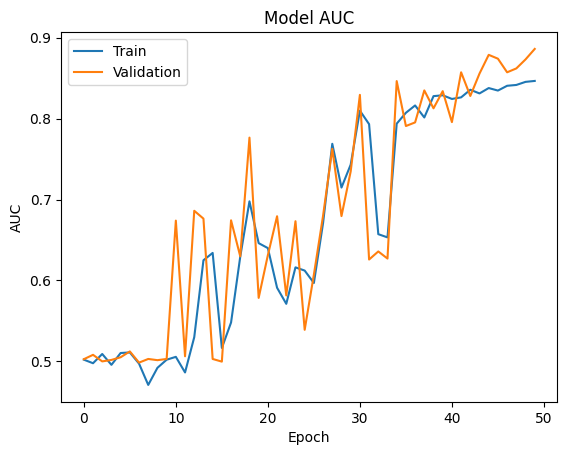

In [17]:
# Plot training & validation AUC values
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()